In [72]:
import swarms
import pread as pd
from numpy import linspace, logspace, pi, array, exp
import matplotlib.pyplot as plt

In [113]:
RHO=1500
M0 = .1 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 10 * 3.828e26;
M_s = 1.86 * 1.989e30; M_pl = 318 * 5.972e24; a_pl = 50 * 1.496e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 10 * 3.086e16
argv = [M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr, d_pl]

In [174]:
time = linspace(1.5e7, 1e9, 500)
lamb = 1.65e-6
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)
type_star = "M"

In [175]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [176]:
def Finc(T_s, apl, R_s, R_pl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = (sig * T_s**4) / (pi * R_pl**2)
    return part1 * (R_s/a_pl)**2
    #return pi * R_pl**2 * Bnu / d_pl**2
    #return (f/4) * (R_s / a_pl)**2 * F_star

In [177]:
def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

In [178]:
#def Fplt(B_nu_plt, R_plt, d_plt):
#    return B_nu_plt * pi * R_plt ** 2 / d_plt ** 2

In [179]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pd.Pread('data', 'Z002', 'pltlum_M318Z002.csv') 

In [180]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

In [181]:
def lum_to_temp2(R, a, T_s):
    part1 = (R / a)**0.5
    return (part1 / 2**0.5)*T_s

In [182]:
def planet_plt():
    if type_star == "A":
        R_s = 1.7 * 6.955e08
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        R_s = 1 * 6.955e08
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        R_s = 0.32 * 6.955e08
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    fplt_list = []
    finc_plt_list = []
    fscat_plt_list = []
    a_swarm = []
    
    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(1e7)
    T_star = s.stellarTemp()
    #print(T_star)
    B_nu = s.computeBmu(lamb, T_star)
    F_star = Fstar(L_s, B_nu, T_star, a_pl)


    for i in range(len(time)):
        index = data.find_time_index(time[i])
        if (index > -1):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                    a_pl, data.radii[index], eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[i])
            a_swarm.append(s2.computeAtot())
            
            #T_plt = lum_to_temp(data.lumin[index], data.radii[index]) #lum_to_temp(R_s, a_pl, T_star)
            T_plt = lum_to_temp2(R_s, a_pl, T_star)
            B_nu_plt = s2.computeBmu(lamb, T_plt)
            F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, d_pl)
            F_inc = Finc(T_star, a_pl, R_s, data.radii[index])#(data.radii[index], B_nu_plt, d_pl)
            F_scat = Fscat(F_star, data.radii[index], 0.32, 0.5, d_pl)
            fplt_list.append(F_plt/1e-26)
            finc_plt_list.append(F_inc/1e-26)
            fscat_plt_list.append(F_scat/1e-26)

    F_star = F_star / 1e-26
    contrast_rat_plt = array(fplt_list) / F_star
    contrast_rat_inc_plt = array(finc_plt_list) / F_star
    contrast_rat_scat_plt = array(fscat_plt_list) / F_star
    print("planet temp")
    print(T_plt)
    print("plt radii")
    print("{0:.3e}".format(data.radii[0]))
    print("plt lumin")
    print(data.lumin[0])
    print("fplt")
    print(fplt_list[0])
    print("no incident")
    print(contrast_rat_plt[0])
    print("incident only")
    print(contrast_rat_inc_plt[0])
    print("----------------------------------------------")
    return contrast_rat_plt, contrast_rat_inc_plt, contrast_rat_scat_plt, a_swarm

In [183]:
def swarm_plt():
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(1e7)
    T_star = s.stellarTemp()
    B_nu = s.computeBmu(lamb, T_star)
    F_star = Fstar(L_s, B_nu, T_star, a_pl)/1e-26
    print("Fstar")
    print(F_star)

    fth_list = []
    fs_list = []
    if (a_plv is not None):
        for i in range(len(time)):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                    a_pl, R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[i])

            F_th = s2.computeFth(array([lamb]), swarm=True)
            F_s = s2.computeFs(array([lamb]), 0.32, 0.08, swarm=True)

            fth_list.append(F_th[0]/1e-26)
            fs_list.append(F_s[0]/1e-26)

    contrast_ratio_apl_th = array(fth_list) / F_star
    contrast_ratio_apl_s = array(fs_list) / F_star

    print("fs_list_elem")
    print(fs_list[250])
    #     print("apl")
    #     print("{0:.3e}".format(a_plv[250]/1.496e11))
    #     print("contrast ratio")
    #     print(contrast_ratio_apl_th[250])
    #     print(fth_list[50])
    return contrast_ratio_apl_th, contrast_ratio_apl_s

In [184]:
contrast_rat_swm, contrast_rat_s_swm = swarm_plt()
contrast_rat_plt, contrast_rat_inc_plt, contrast_rat_scat_plt, a_swarm = planet_plt()

Fstar
1504447820.0084605
fs_list_elem
1.0350848875449272e-08
planet temp

C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)



11.571216363388174
plt radii
9.116e+07
plt lumin
4.709468854669795e+20
fplt
0.0
no incident
0.0
incident only
0.010760392108245616
----------------------------------------------


In [185]:
r_swarm = []
for i in range(len(a_swarm)):
    r_swarm.append((a_swarm[i]/pi)**0.5)

print(a_swarm[0])
s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                    d_pl, correction=True, alpha=1./1.2)
s.updateSwarm(1e7)
T_star = s.stellarTemp()
print(T_star)
B_nu = s.computeBmu(lamb, T_star)
F_star = Fstar(L_s, B_nu, T_star, a_pl)
print("Fstar")
print(F_star)

swarm_scat = []
for i in range(len(r_swarm)):
    swarm_scat.append(Fscat(F_star, r_swarm[i], 0.32, 0.08, d_pl))
    
for i in range(len(swarm_scat)):
    swarm_scat[i] = (swarm_scat[i]/F_star)

area_ratio=[]
for i in range(len(a_swarm)):
    area_ratio.append(pi*R_pl**2 / a_swarm[i])

8.093709623433866e+19
9000.0
Fstar
2.4869745810343957e-15


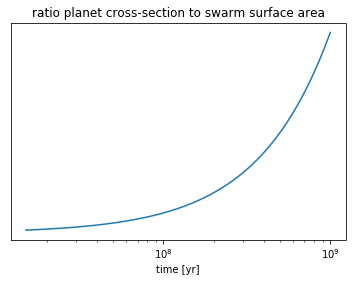

0.00018996088448938357


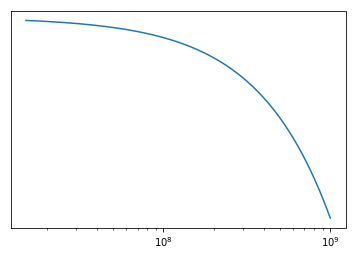

C:\Users\loloynage\AppData\Roaming\Python\Python36\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


0.013496991625857343
6.916318226206648e-18


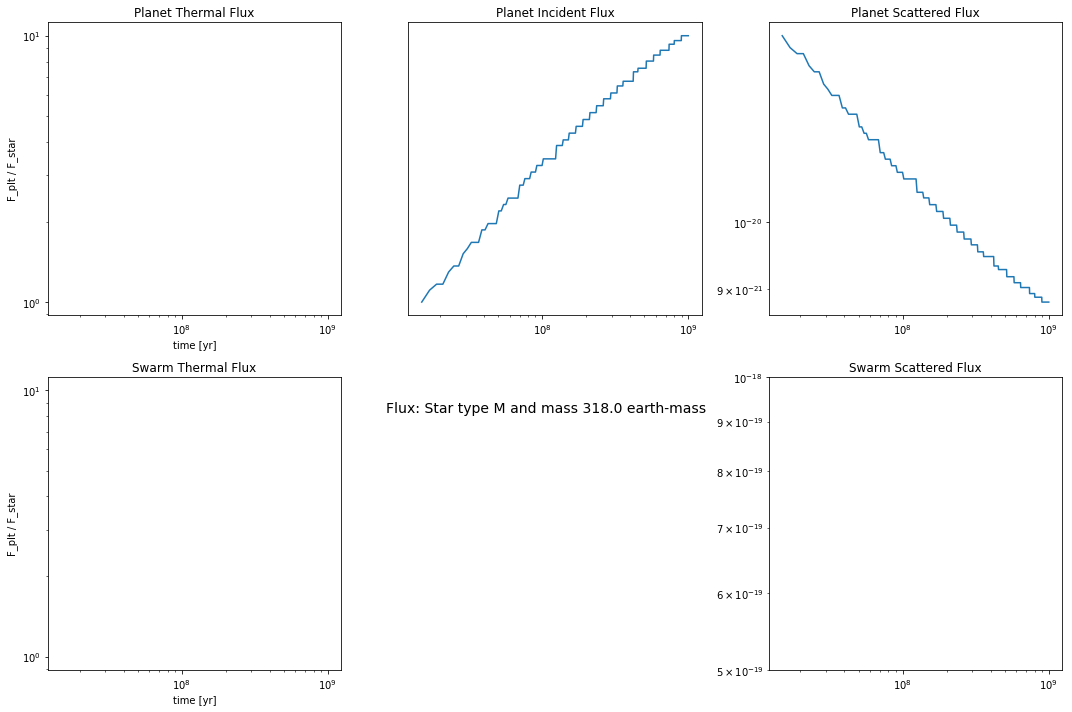

In [186]:
plt.figure(3)
plt.title("ratio planet cross-section to swarm surface area")
plt.loglog(time, area_ratio)
plt.xlabel("time [yr]")
plt.show()

print(area_ratio[50])

plt.figure(4)
plt.loglog(time, swarm_scat)
plt.show()

plt.figure(5, figsize=(15,10))
plt.subplot(231)
plt.loglog(time, contrast_rat_plt)
plt.title("Planet Thermal Flux")
plt.xlabel("time [yr]")
plt.ylabel("F_plt / F_star")
plt.subplot(232)
plt.loglog(time, contrast_rat_inc_plt)
plt.title("Planet Incident Flux")
plt.subplot(233)
plt.loglog(time, contrast_rat_scat_plt)
plt.title("Planet Scattered Flux")

print(contrast_rat_inc_plt[50])
ax = plt.subplot(234)
plt.loglog(time, contrast_rat_swm, 'r')
plt.title("Swarm Thermal Flux")
plt.xlabel("time [yr]")
plt.ylabel("F_plt / F_star")

plt.text(1.70, 0.88, "Flux: Star type "+str(type_star)+" and mass " + str(M_pl/5.972e24)+" earth-mass",
         horizontalalignment='center',
         fontsize=14,
         transform = ax.transAxes)

plt.subplot(236)
plt.loglog(time, contrast_rat_s_swm, 'r')
print(contrast_rat_s_swm[50])
plt.gca().set_ylim(5e-19, 1e-18)
plt.title("Swarm Scattered Flux")
plt.tight_layout()
plt.show()